# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 13:41:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [     <=>            ] 201.24M  33.7MB/s    in 6.0s    

2024-10-24 13:41:20 (33.4 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('/content/data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)
X_st_train = scaler.transform(X_train)
X_st_train = pd.DataFrame(data=X_st_train, columns=df.columns[1:])
X_st_test = scaler.transform(X_test)
X_st_test = pd.DataFrame(data=X_st_test, columns=df.columns[1:])

In [ ]:
sum(X_st_train.isna().sum())

0

In [ ]:
sum(X_st_test.isna().any())

0

Пропусков в данных нет

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

Импортируем из sklearn ridge регрессию и RMSE.


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

alpha = [0 ,0.005, 0.01, 0.05, 1, 3, 5, 7, 10]

rmse_list_train = []
rmse_list_test = []

for a in alpha:
  rr = Ridge(a).fit(X_st_train, y_train)
  rmse_list_train.append(root_mean_squared_error(y_train, rr.predict(X_st_train)))
  rmse_list_test.append(root_mean_squared_error(y_test, rr.predict(X_st_test)))

print(f"Best alpha for train {alpha[np.argmin(rmse_list_train)]} with RMSE {min(rmse_list_train)}")
print(f"Best alpha for test {alpha[np.argmin(rmse_list_test)]} with RMSE {min(rmse_list_test)}")

Best alpha for train 0 with RMSE 9.552822967904037
Best alpha for test 0 with RMSE 9.510160707488621


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем, для этого импортируем DummyRegression из sklearn.

In [ ]:
from sklearn.dummy import DummyRegressor

dumb = DummyRegressor(strategy='mean').fit(X_st_train, y_train)

print(f"RMSE on train {root_mean_squared_error(y_train, dumb.predict(y_train))}")
print(f"RMSE on test {root_mean_squared_error(y_test, dumb.predict(y_test))}")

RMSE on train 10.939755150678016
RMSE on test 10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

Возьмем часть данных, чтобы быстрее считал.

In [ ]:
X_train_short = X_st_train.values[:5000, :]
y_train_short = y_train[:5000]
X_test_short = X_st_test.values[:1000,:]
y_test_short = y_test[:1000]

In [ ]:
class MariaNet(nn.Module):
  def __init__(self, n_feat, n_out):
    super().__init__()
    self.layer = nn.Linear(n_feat, n_out)

  def forward(self, X):
    return self.layer(X)

In [ ]:
model = MariaNet(X_train.shape[1], 1)

In [ ]:
X_train_tensor = torch.tensor(X_train_short, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_short, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_short, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_short, dtype=torch.float32)

In [ ]:
set_random_seed(42)

In [ ]:
eta = 0.1
epoches = 10

rmse_list_train = []
rmse_list_test = []

weights = model.layer.weight
bias = model.layer.bias

for i in range(epoches):
    model.train()
    predictions_train = model(X_train_tensor)
    train_loss = torch.mean((predictions_train - y_train_tensor)**2)
    rmse_list_train.append((train_loss.item())**(1/2))
    train_loss.backward()

    with torch.no_grad():
      weights -= eta * weights.grad
      bias -= eta * bias.grad

    model.zero_grad()

    model.eval()
    predictions = model(X_test_tensor)
    test_loss = torch.mean((predictions - y_test_tensor)**2)
    rmse_list_test.append((test_loss.item())**(1/2))
    print(f"In epoch {i+1} RMSE on Train equals {(train_loss.item())**(1/2)} and RMSE on Test equals {(test_loss.item())**(1/2)}")

In epoch 1 RMSE on Train equals 1998.5963199205587 and RMSE on Test equals 1593.4612483521523
In epoch 2 RMSE on Train equals 1573.0236012215455 and RMSE on Test equals 1289.7550154971293
In epoch 3 RMSE on Train equals 1259.225108945974 and RMSE on Test equals 1041.2455882259478
In epoch 4 RMSE on Train equals 1014.1754655876862 and RMSE on Test equals 847.617322262824
In epoch 5 RMSE on Train equals 820.278344527027 and RMSE on Test equals 687.8951137346448
In epoch 6 RMSE on Train equals 665.9914836167202 and RMSE on Test equals 565.2809312633851
In epoch 7 RMSE on Train equals 542.8331638266034 and RMSE on Test equals 461.01164234214303
In epoch 8 RMSE on Train equals 444.37524613214 and RMSE on Test equals 383.4290596055547
In epoch 9 RMSE on Train equals 365.6903360426688 and RMSE on Test equals 314.47900863968647
In epoch 10 RMSE on Train equals 302.99207136903766 and RMSE on Test equals 266.26627004279004


Теперь визуализируем, что у нас получилось

In [ ]:
rmse_list_train, rmse_list_test

([1998.5963199205587,
  1573.0236012215455,
  1259.225108945974,
  1014.1754655876862,
  820.278344527027,
  665.9914836167202,
  542.8331638266034,
  444.37524613214,
  365.6903360426688,
  302.99207136903766],
 [1593.4612483521523,
  1289.7550154971293,
  1041.2455882259478,
  847.617322262824,
  687.8951137346448,
  565.2809312633851,
  461.01164234214303,
  383.4290596055547,
  314.47900863968647,
  266.26627004279004])

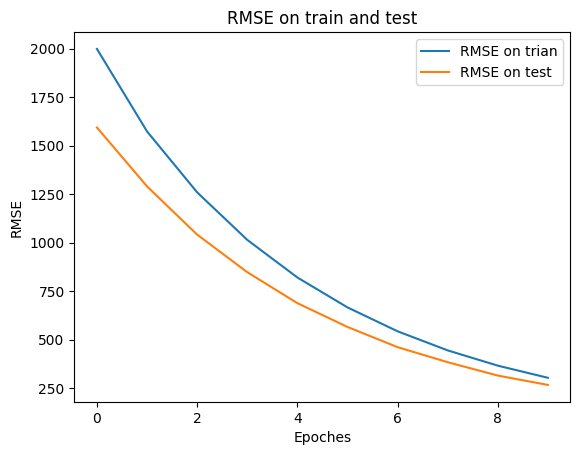

In [ ]:
plt.plot(rmse_list_train, label='RMSE on trian')
plt.plot(rmse_list_test, label='RMSE on test')
plt.title('RMSE on train and test')
plt.xlabel('Epoches')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
print(f"The best RMSE on train {rmse_list_train[-1]}")
print(f"The best RMSE on test {rmse_list_test[-1]}")


The best RMSE on train 302.99207136903766
The best RMSE on test 266.26627004279004


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

Теперь нужно весь датасет сделать в тензор

In [ ]:
X_train_tensor_orig = torch.tensor(X_st_train.values, dtype=torch.float32)
y_train_tensor_orig = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor_orig = torch.tensor(X_st_test.values, dtype=torch.float32)
y_test_tensor_orig = torch.tensor(y_test, dtype=torch.float32)

Для первого эксперимента я просто добавлю пару слоев и возьму улучшенный стохастический ГС и посмотрю, что получится.


In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [ ]:
train_set = RandomDataset(X_train_tensor_orig, y_train_tensor_orig)
test_set = RandomDataset(X_test_tensor_orig, y_test_tensor_orig)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8192, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8192, num_workers=0, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 75),
    nn.ReLU(),
    nn.Linear(75, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25,1)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.05, weight_decay = 0.5, eps = 0.005)

In [ ]:
epoches = 70

rmse_train_list_1 = []
rmse_test_list_1 = []

for epoch in range(epoches):
  train_loss = 0.0
  model.train()
  for X_train, y_train in train_loader:
    optimizer.zero_grad()
    pred_y = model(X_train)
    criterion = nn.MSELoss()
    loss = criterion(pred_y, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * X_train.shape[0]

  train_loss /= len(train_loader.dataset)
  rmse_train_list_1.append(np.sqrt(train_loss))


  test_loss = 0.0
  model.eval()
  for X_test, y_test in test_loader:
    with torch.no_grad():
      pred_test = model(X_test)
      loss = criterion(pred_test, y_test)

      test_loss += loss.item() * X_test.shape[0]


  test_loss /= len(test_loader.dataset)
  rmse_test_list_1.append(np.sqrt(test_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8192])) that is different to the input size (torch.Size([8192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4963])) that is different to the input size (torch.Size([4963, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2478])) that is different to the input size (torch.Size([2478, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse

In [ ]:
rmse_test_list_1

[357.06282090899504,
 162.50287224951202,
 99.31334801320071,
 84.70378834232444,
 80.04271932214431,
 97.06625192284383,
 103.19282119487505,
 102.93777590456766,
 61.347968676272615,
 74.19564469333231,
 65.31840500281487,
 116.69677669271913,
 62.991648164284406,
 48.369978274576525,
 46.60122786259609,
 52.4781396655436,
 64.59202323560692,
 64.03458192701676,
 118.5082068309237,
 41.95036826486711,
 37.56925324463423,
 46.892572326473854,
 51.18569335628025,
 45.04447256681911,
 49.251228677310785,
 49.38733012211836,
 40.986765694998276,
 44.91587042834259,
 65.22127937206432,
 39.960350486329695,
 41.84692934476891,
 37.220130502097504,
 34.828177730121254,
 46.17050367465995,
 72.45547637451848,
 47.28586594273493,
 43.65245500077006,
 59.5742320409022,
 57.13639236146656,
 65.39589825596201,
 114.38747475754624,
 103.67440491312465,
 81.56830711015803,
 76.74266264133384,
 53.01012961456511,
 33.99928110999475,
 43.52355912792091,
 49.153659033911524,
 51.58007586444168,
 85.1

У нас получаются очень большие значения rmse, это может быть связано с тем, что у меня большие гиперпараметры. Перейдем к другой попытке.

In [ ]:
y_st_train = scaler.fit_transform(y_train.reshape(-1,1))
y_st_test = scaler.transform(y_test.reshape(-1,1))

X_train_tensor_orig_1 = torch.tensor(X_st_train.values, dtype=torch.float32)
y_train_tensor_orig_1 = torch.tensor(y_st_train, dtype=torch.float32)
X_test_tensor_orig_1 = torch.tensor(X_st_test.values, dtype=torch.float32)
y_test_tensor_orig_1 = torch.tensor(y_st_test, dtype=torch.float32)

In [ ]:
train_set = RandomDataset(X_train_tensor_orig_1, y_train_tensor_orig_1)
test_set = RandomDataset(X_test_tensor_orig_1, y_test_tensor_orig_1)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8192, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8192, num_workers=0, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 75),
    nn.Dropout(0.1),
    nn.SiLU(),
    nn.Linear(75, 50),
    nn.SiLU(),
    nn.Linear(50, 25),
    nn.SiLU(),
    nn.Linear(25,1)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay = 0.5, eps = 0.00005)

In [ ]:
set_random_seed(42)
epoches = 70

rmse_train_list_2 = []
rmse_test_list_2 = []

for epoch in range(epoches):
  train_loss = 0.0
  model.train()
  for X_train, y_train in train_loader:
    optimizer.zero_grad()
    pred_y = model(X_train)
    criterion = nn.MSELoss()
    loss = criterion(pred_y, y_train)
    loss_inverse = criterion(torch.tensor(scaler.inverse_transform(pred_y.detach())), torch.tensor(scaler.inverse_transform(y_train.detach())))
    loss.backward()
    optimizer.step()

    train_loss += loss_inverse.item() * X_train.shape[0]

  train_loss /= len(train_loader.dataset)
  rmse_train_list_2.append(np.sqrt(train_loss))


  test_loss = 0.0
  model.eval()
  for X_test, y_test in test_loader:
    with torch.no_grad():
      pred_test = model(X_test)
      loss = criterion(torch.tensor(scaler.inverse_transform(pred_test)), torch.tensor(scaler.inverse_transform(y_test)))

      test_loss += loss.item() * X_test.shape[0]


  test_loss /= len(test_loader.dataset)
  rmse_test_list_2.append(np.sqrt(test_loss))

In [ ]:
np.min(rmse_test_list_2), np.mean(rmse_test_list_2)

(8.768392521528545, 8.793267698678234)

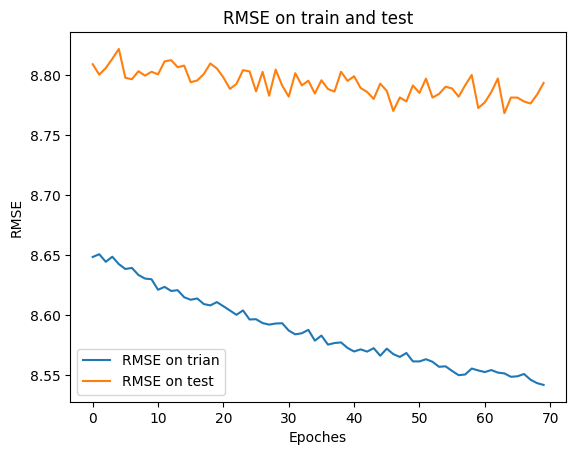

In [ ]:
plt.plot(rmse_train_list_2, label='RMSE on trian')
plt.plot(rmse_test_list_2, label='RMSE on test')
plt.title('RMSE on train and test')
plt.legend()
plt.xlabel('Epoches')
plt.ylabel('RMSE')
plt.show()

Почти получили тот результат, который максимальный. Нормировка таргета, изменение ReLU на SiLU, и маленькое уменьшение гиперпараметров дали свои плады. Сделаю 3-ую попытку и напишу отчет.

In [ ]:
model = nn.Sequential(
    nn.Linear(90, 75),
    nn.Dropout(0.1),
    nn.SiLU(),
    nn.Linear(75, 50),
    nn.SiLU(),
    nn.Linear(50, 25),
    nn.SiLU(),
    nn.Linear(25,1)
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay = 0.5, eps = 0.005)

In [ ]:
set_random_seed(42)
epoches = 99

rmse_train_list_3 = []
rmse_test_list_3 = []

for epoch in range(epoches):
  train_loss = 0.0
  model.train()
  for X_train, y_train in train_loader:
    optimizer.zero_grad()
    pred_y = model(X_train)
    criterion = nn.MSELoss()
    loss = criterion(pred_y, y_train)
    loss_inverse = criterion(torch.tensor(scaler.inverse_transform(pred_y.detach())), torch.tensor(scaler.inverse_transform(y_train.detach())))
    loss.backward()
    optimizer.step()

    train_loss += loss_inverse.item() * X_train.shape[0]

  train_loss /= len(train_loader.dataset)
  rmse_train_list_3.append(np.sqrt(train_loss))


  test_loss = 0.0
  model.eval()
  for X_test, y_test in test_loader:
    with torch.no_grad():
      pred_test = model(X_test)
      loss = criterion(torch.tensor(scaler.inverse_transform(pred_test)), torch.tensor(scaler.inverse_transform(y_test)))

      test_loss += loss.item() * X_test.shape[0]


  test_loss /= len(test_loader.dataset)
  rmse_test_list_3.append(np.sqrt(test_loss))

In [ ]:
min(rmse_test_list_3)

8.968627523510605

Такая себе попытка вышла, вторая лучше (в разы)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1. Нужно отметить, что на первой попытке я попробовал просто понять как работают данные и насколько сильные методы нужны, чтобы получить хороший результат. Там я использовал AdamW (по наставлению Фила), ReLU (база) и больше ничего интересного. Как оказалось, тяжело выбить хорошее качество.

2. Для второй попытки я просто использовал все что можно: и дропаут, и нормировал таргет (возвращал обратно потом кнш), и даже ReLU поменял, потому что он для меня очень странный и я не понимаю как можно занулить часть и все равно получить хороший градиент, поэтому я взял SiLU, она частично сигмоидная функция и частично линейная (мне показалось, что он будет лучше). И я чуть-чуть поменял гиперпараметры для AdamW. В итоге получил значение RMSE меньше чем 8.8 (этого мне хватит). Можно сказать, что идеи были удачные.

3. Для 3 эксперимента я ничего не стал придумывать, просто увеличил количество эпох, и уменьшил лернинг рейт (очень плохо все вышло).